# Clustering of the VAE latent space for anomaly detection of diverse time-series sensor data
Trained on non-fault data to learn a normal expectation.

Build the model for 512 time points per cycle with 14 sensors.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, roc_curve, auc

In [3]:
from IPython.core.debugger import set_trace

In [4]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / 'src'))

from clustering import *
device

device(type='cuda', index=0)

In [5]:
desc

'accumulator'

In [6]:
model = VAE1D(size, n_channels, n_latent)
model = model.to(device)
print(f"Time-series size = {size}, number of sensors = {n_channels}, "
      f"latent size = {n_latent}")

Time-series size = 512, number of sensors = 14, latent size = 50


Load the best parameters from training.

In [7]:
model = load_checkpoint(model, device)

Checkpoint Performance:
Validation loss: 14.268
Epoch: 210


Next we need to load the datasets of sensors readings.

In [8]:
data_path = Path(f'../data/hydraulic/{desc}')
train_dl, val_dl, test_dl = load_datasets(data_path)

In [9]:
print(len(train_dl), len(val_dl), len(test_dl))

27 7 1157


Run model on training set combined with validation set to get latent vectors to use for building clustering model.

In [10]:
train_latents, targets = compute_latents(train_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(train_latents.shape)

100%|██████████| 27/27 [00:04<00:00,  5.85it/s]

(839, 50)


In [11]:
val_latents, targets = compute_latents(val_dl, model)
assert np.all(targets == 0), 'Invalid training data - faults present'
print(val_latents.shape)

100%|██████████| 7/7 [00:01<00:00,  5.03it/s]

(209, 50)


In [12]:
latents = np.vstack([train_latents, val_latents])
print(latents.shape)

(1048, 50)


To evaluate the hyperparameter I want to minimize the information criterion as a measure of model efficiency. I prefer the bayesian version over akaike for this because it penalizes complex models more. My intuition is that a simpler clustering will perform better for general cases.

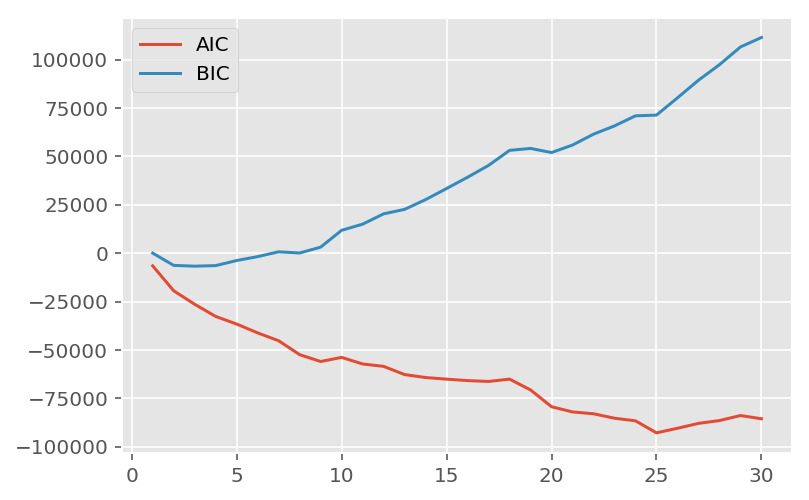

In [13]:
# Select model based on lowest BIC score
aic = []
bic = []
n_range = range(1, 31)
for n in n_range:
    gmm = GaussianMixture(n_components=n,
                          covariance_type='full',
                          random_state=0)
    gmm = gmm.fit(latents)
    aic.append(gmm.aic(latents)) 
    bic.append(gmm.bic(latents))
plt.plot(n_range, aic, label="AIC")
plt.plot(n_range, bic, label='BIC')
plt.legend()

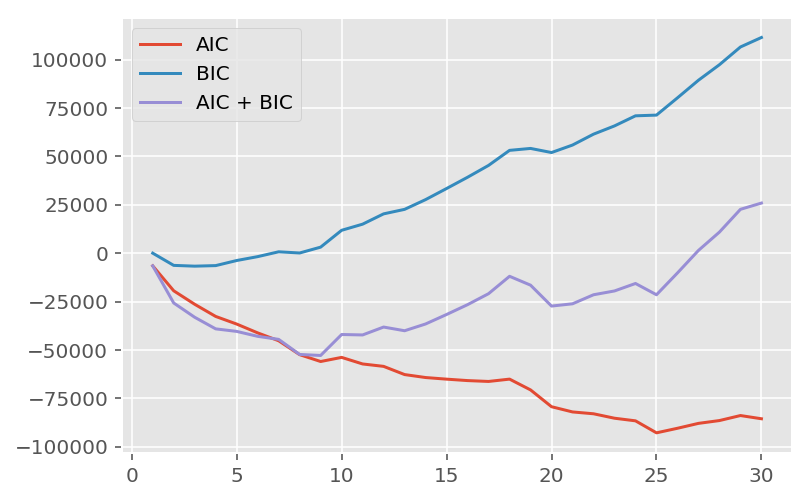

In [19]:
# Compare sum of AIC and BIC
plt.plot(n_range, aic, label="AIC")
plt.plot(n_range, bic, label='BIC')
tic = [a + b for a, b in zip(aic, bic)]
plt.plot(n_range, tic, label='AIC + BIC')
plt.legend()

In [20]:
# Select hyperparameter that minimizes BIC
n = n_range[np.argmin(bic)]
n

9

In [21]:
# Fit model and make predicts
gmm = GaussianMixture(n_components=n,
                      covariance_type='full',
                      random_state=0)
gmm = gmm.fit(latents)
cluster = gmm.predict(latents)
prob = gmm.predict_proba(latents)
print(f'Minimum probability = {prob.max(axis=1).min()}')

Minimum probability = 0.9999685695566557


PCA can be used to visualize the clustering of the training data.

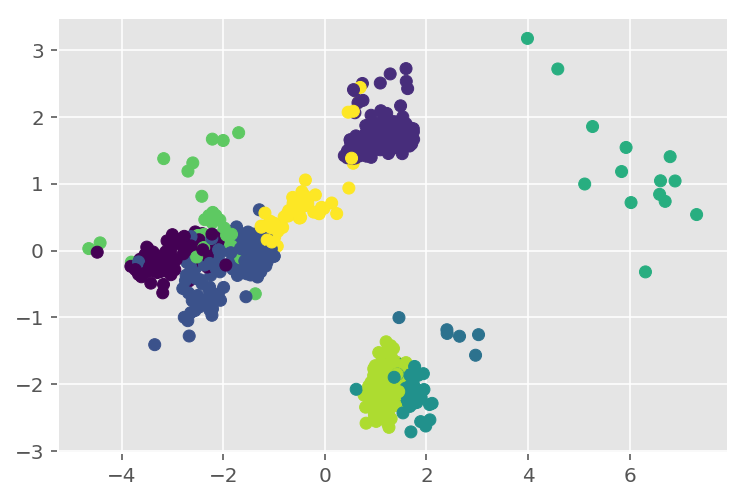

In [25]:
# Project to 2D for plotting
pca = PCA(n_components=2)
train_pca = pca.fit_transform(latents)

plt.scatter(train_pca[:, 0], train_pca[:, 1], c=cluster, cmap='viridis')

Let's calculate probabilities on the test dataset to look for an outlier threshold.

In [26]:
# Use the test set with the anomaly labels as targets
test_latents, targets = compute_latents(test_dl, model)
print(test_latents.shape)
print(test_dl.dataset.classes)

100%|██████████| 1157/1157 [00:07<00:00, 147.71it/s]

(1157, 50)
['fail', 'norm']


In [32]:
sorted_idx = np.argsort(targets)[::-1]
sorted_idx[:10]

array([1156,  250,  756,  762,  268,  266,  265,  767,  264,  774])

In [122]:
# Manually calculate the probability of each point belonging to a cluster
means = gmm.means_
covars = gmm.covariances_
print(means.shape, covars.shape)

probs = np.zeros(test_latents.shape[0])
log_probs = np.zeros([test_latents.shape[0],
                      means.shape[0]])
for k in range(means.shape[0]):
    probs += multivariate_normal.pdf(test_latents,
                                     mean=means[k, :],
                                     cov=covars[k, :, :])
    # In log space addition is multiplication so will take max as a lower bound
    log_probs[:, k] = multivariate_normal.logpdf(test_latents,
                                                 mean=means[k, :],
                                                 cov=covars[k, :, :])
log_probs = log_probs.max(axis=1)
print(probs.shape, log_probs.shape)

(9, 50) (9, 50, 50)
(1157,) (1157,)


In [123]:
# Set all zero probabilities to min non-zero probability
probs[probs == 0] = probs[probs != 0].min()
log_probs_manual = np.log(probs)

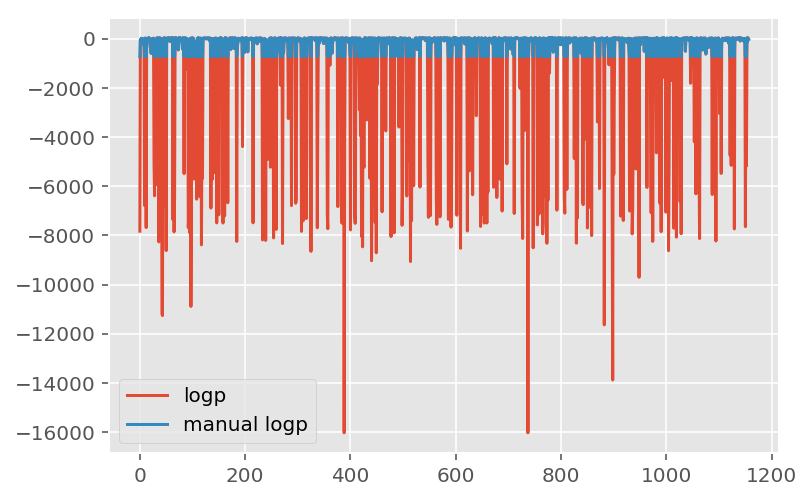

In [124]:
# The manual approach to log p is the same but clipped to to vanishing probability near zero
plt.plot(log_probs, label='logp')
plt.plot(log_probs_manual, label='manual logp')
plt.legend()

In [125]:
# Average fault log prob
log_probs[targets == 0].mean()

-1692.202740812063

In [126]:
# Average normal log prob
log_probs[targets == 1].mean()

-85.78267711536411

We're on the right track here. The anomalies have a lower log probability on average and the seperation looks to be much better than with MSE. Lets compare the histograms and dive into the accuracy metrics on the test dataset.

In [127]:
normal_logp = log_probs[targets == 1]
print('Normal')
print('95% =', np.percentile(normal_logp, 95))
print('75% =', np.percentile(normal_logp, 75))
print('50% =', np.percentile(normal_logp, 50))
print('25% =', np.percentile(normal_logp, 25))
print('5% =', np.percentile(normal_logp, 5))
print('Samples:', normal_logp.size)

Normal
95% = 42.58911660598359
75% = 33.25395673888237
50% = 24.430455869710613
25% = 5.9420682398878455
5% = -300.22759337014554
Samples: 349


In [128]:
anomaly_logp = log_probs[targets == 0]
print('Anomaly')
print('95% =', np.percentile(anomaly_logp, 95))
print('75% =', np.percentile(anomaly_logp, 75))
print('50% =', np.percentile(anomaly_logp, 50))
print('25% =', np.percentile(anomaly_logp, 25))
print('5% =', np.percentile(anomaly_logp, 5))
print('Samples:', anomaly_logp.size)

Anomaly
95% = 32.88205661221651
75% = 10.174630976181737
50% = -73.02979297513629
25% = -665.024383238701
5% = -7842.450111632377
Samples: 808


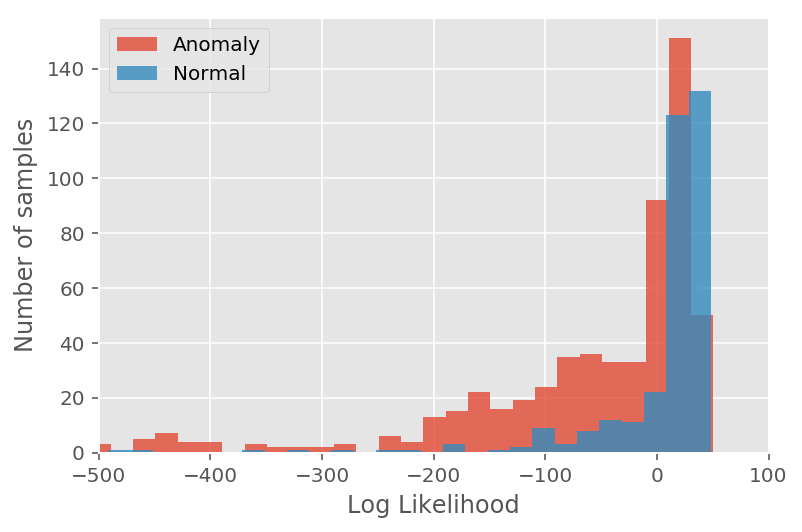

In [144]:
bin_size = 20
plt.hist(anomaly_logp, label='Anomaly', alpha=0.8,
         bins=np.arange(anomaly_logp.min(), anomaly_logp.max() + bin_size, bin_size))
plt.hist(normal_logp, label='Normal', alpha=0.8,
         bins=np.arange(normal_logp.min(), anomaly_logp.max() + bin_size, bin_size))
plt.xlabel('Log Likelihood')
plt.ylabel('Number of samples')
plt.xlim([-500, 100])
plt.legend()

In [103]:
min_threshold = np.percentile(normal_logp, 5)
max_threshold = np.percentile(normal_logp, 95)
thresholds = np.linspace(min_threshold, max_threshold, 1000)
f1_scores = np.zeros(thresholds.size)
auc_scores = np.zeros(thresholds.size)
acc_scores = np.zeros(thresholds.size)
for i, threshold in enumerate(thresholds):
    anomalies = log_probs < threshold
    # Must invert targets because fault=0
    f1_scores[i] = f1_score(1 - targets, anomalies)
    auc_scores[i] = roc_auc_score(1 - targets, anomalies)
    acc_scores[i] = accuracy_score(1 - targets, anomalies)

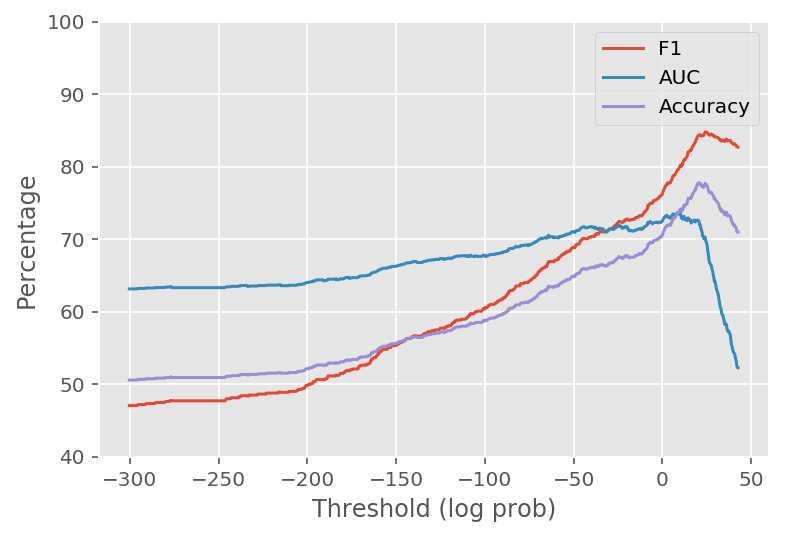

In [104]:
plt.plot(thresholds, 100 * f1_scores, label='F1')
plt.plot(thresholds, 100 * auc_scores, label='AUC')
plt.plot(thresholds, 100 * acc_scores, label='Accuracy')
plt.ylim([40, 100])
plt.ylabel('Percentage')
plt.xlabel('Threshold (log prob)')
plt.legend()

In [105]:
best_thresholds = [thresholds[np.argmax(acc_scores)],
                   thresholds[np.argmax(f1_scores)],
                   thresholds[np.argmax(auc_scores)]]
print(best_thresholds)
print('Average:', np.mean(best_thresholds))

[20.626884935841133, 24.0584836343009, 9.988928970615916]
Average: 18.224765846919315


It is necessary to select a threshold without access to labelled target data. The F1 threshold appears to be a good choice because it balances true and false positives. It corresponds to a 10th percentile limit on the normal log probabilities. Ultimately the end user would have some control over the threshold if nuisance faults were a problem.

In [106]:
# Max scores
print(acc_scores.max(), f1_scores.max(), auc_scores.max())

0.7778738115816768 0.8478773584905659 0.7368453714999008


Text(0.5,0,'False Positive Rate')

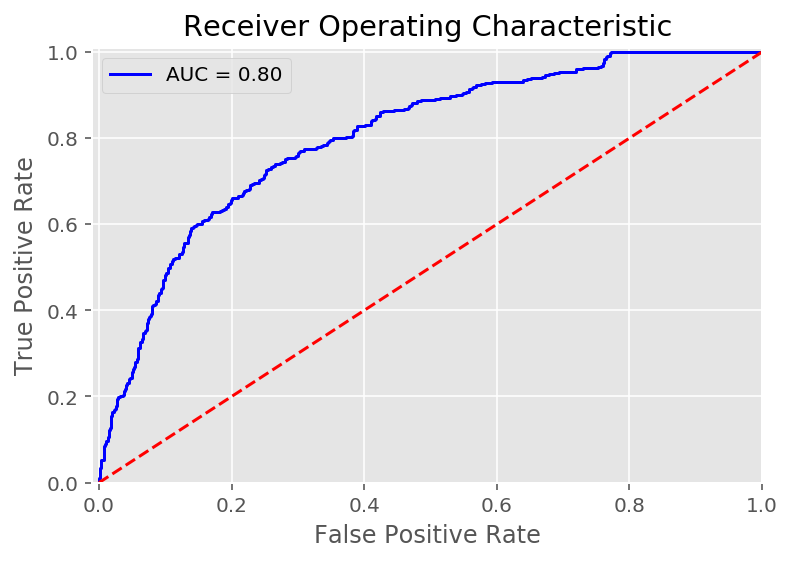

In [107]:
# Plot the ROC curve for visualization of model performance
fpr, tpr, roc_thresholds = roc_curve(targets, log_probs)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f'AUC = {auc(fpr, tpr):0.2f}')
plt.legend()
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

As a final confirmation of the approach I want to check the metrics on the training dataset alone. Ideally all would classify as normal.

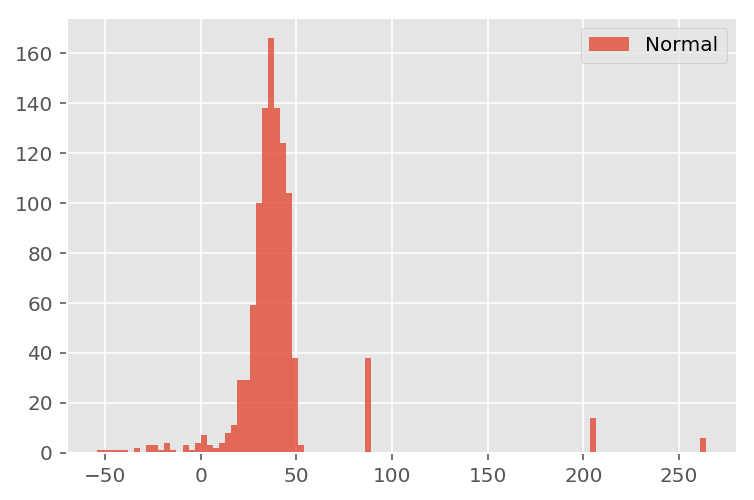

In [114]:
# Calculate log probabilities on training set
train_probs = np.zeros([latents.shape[0],
                        means.shape[0]])
for k in range(means.shape[0]):
    train_probs[:, k] = multivariate_normal.logpdf(
        latents, mean=means[k, :], cov=covars[k, :, :])
train_probs = train_probs.max(axis=1)

# Plot histogram to find reasonable thresholds
plt.hist(train_probs, bins=100, label='Normal', alpha=0.8)
plt.legend()

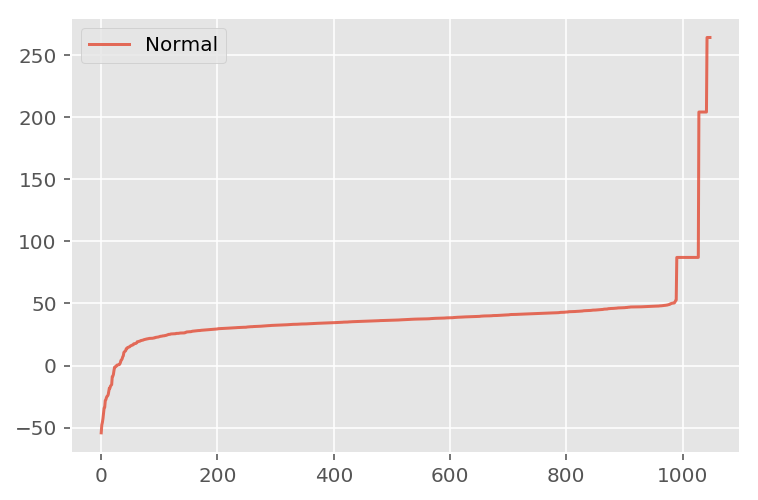

In [116]:
plt.plot(np.sort(train_probs), label='Normal', alpha=0.8)
plt.legend()

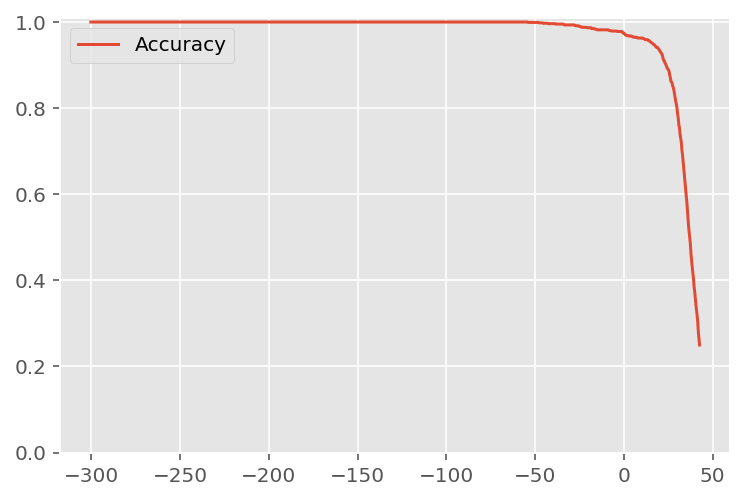

In [118]:
# Sweep thresholds and calculate metrics
train_targets = np.zeros(train_probs.shape[0])
train_acc_scores = np.zeros(thresholds.size)
for i, threshold in enumerate(thresholds):
    anomalies = train_probs < threshold
    train_acc_scores[i] = accuracy_score(train_targets, anomalies)

# Plot performance
plt.plot(thresholds, train_acc_scores, label='Accuracy')
plt.ylim([0, 1.01])
plt.legend()

In [134]:
# For comparison the training percentiles
print('Normal')
for p in range(5, 96, 5):
    print(f'{p}% = ', np.percentile(train_probs, p))

Normal
5% =  16.28800491745816
10% =  23.782949244793134
15% =  27.67720730457184
20% =  29.86264001289252
25% =  31.438875551683704
30% =  32.76597277054786
35% =  33.91523948328431
40% =  35.00677822614578
45% =  35.99803525333844
50% =  37.03049958064119
55% =  38.071913266546076
60% =  39.231467455141825
65% =  40.345656279617806
70% =  41.63482661270632
75% =  42.577960898255185
80% =  44.32949624674438
85% =  46.43858548720986
90% =  47.592313634326075
95% =  87.08124552876689


A decent strategy for initializing the threshold is to set it at the 10th percentile of the training (train and val) log probabilities.

In [137]:
threshold = np.percentile(train_probs, 10)
threshold

23.782949244793134

In [141]:
# Sanity check accuracy using this threshold, should be 90%
corr = (train_probs >= threshold).sum()
count = train_probs.size
print(f"Initial accuracy = {corr}/{count} ({corr / count:.2%})")

Initial accuracy = 943/1048 (89.98%)


Save the means and covariances of the clusters and the threshold.

In [138]:
np.save(Path(f'../models/{date}-{desc}/cluster_means.npy'), means)
np.save(Path(f'../models/{date}-{desc}/cluster_covars.npy'), covars)
np.save(Path(f'../models/{date}-{desc}/threshold.npy'), threshold)